In [47]:
import logging
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import time
import numpy as np
import sys
from models.baseline_snli import encoder
from models.baseline_snli import LSTMTagger
import argparse
from models.snli_data import snli_data
from models.snli_data import w2v
from torch import autograd

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
#Load validation set
w2v_file = "/Users/Lisa/Documents/Grad School/DS-GA 1101/data/snli_preprocess/glove.hdf5"

word_vecs = w2v(w2v_file).word_vecs 
dev_file = "/Users/Lisa/Documents/Grad School/DS-GA 1101/data/snli_preprocess/val.hdf5"

dev_data = snli_data(dev_file, -1)
dev_batches = dev_data.batches

In [7]:
#Load index to word dictionary
word_dict_path = '/Users/Lisa/Documents/Grad School/DS-GA 1101/data/snli_preprocess/word.dict'
idx_to_word = {}
with open(word_dict_path,'r') as inf:
    for line in inf:
        line = line.split()
        idx_to_word[int(line[1])] = line[0]
'''change to 0 indexing'''
idx_to_word = {k-1:v for k,v in idx_to_word.items()}

In [10]:
#Load Model
encode_model_fp = '/Users/Lisa/Documents/Grad School/DS-GA 1101/nlp_project/gru/output/test_tanh_epoch-99_dev-acc-0.788_input-encoder.pt'
atten_model_fp = '/Users/Lisa/Documents/Grad School/DS-GA 1101/nlp_project/gru/output/test_tanh_epoch-99_dev-acc-0.788_lstm.pt'
embedding_size = 300
hidden_size = 200
train_lbl_size = 3
para_init = 0.01

#init
input_encoder = encoder(word_vecs.size(0), embedding_size, hidden_size, para_init)
inter_atten = LSTMTagger(hidden_size, train_lbl_size)

#load state (map_location converts model from gpu to cpu)
input_encoder.load_state_dict(torch.load(encode_model_fp, map_location=lambda storage, loc: storage))
inter_atten.load_state_dict(torch.load(atten_model_fp, map_location=lambda storage, loc: storage))

In [11]:
'''
Evaluate model on the dev set.
This may take a few minutes to run.
'''

input_encoder.eval()
inter_atten.eval()
correct = 0.
total = 0.
predicted_lbls = []
alphas= []

for i in range(len(dev_batches)):
    dev_src_batch, dev_tgt_batch, dev_lbl_batch = dev_batches[i]

    dev_src_batch = Variable(dev_src_batch)
    dev_tgt_batch = Variable(dev_tgt_batch)
    dev_lbl_batch = Variable(dev_lbl_batch)

    dev_src_linear, dev_tgt_linear=input_encoder(
        dev_src_batch, dev_tgt_batch)
    log_prob, alpha=inter_atten(dev_src_linear, dev_tgt_linear, return_attn=True)

    _, predict=log_prob.data.max(dim=1)
    total += dev_lbl_batch.data.size()[0]
    correct += torch.sum(predict == dev_lbl_batch.data)
    predicted_lbls.append(predict)
    alphas.append(alpha)

In [20]:
'''
Each alpha is batch_size x len(premise)
'''
alphas[200].size()

torch.Size([8, 13])

In [21]:
#this is the corresponding premise batch
dev_batches[200][0].size()

torch.Size([8, 13])

In [16]:
#this is the corresponding hypothesis batch
dev_batches[200][1].size()

torch.Size([8, 4])

In [24]:
alphas[batch_num][item_in_batch].data.numpy()

array([  1.44728366e-03,   4.72727261e-04,   9.67186093e-02,
         5.20615559e-03,   1.33558020e-01,   3.13928397e-03,
         4.81196702e-01,   1.03838965e-01,   1.49426027e-03,
         1.23902932e-01,   1.26264906e-02,   2.42413930e-03,
         1.28338381e-03,   1.88678410e-02,   1.04457242e-02,
         3.37747112e-03], dtype=float32)

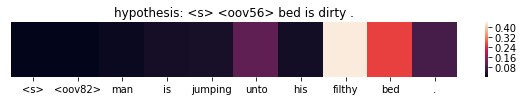

In [49]:
batch_num = 100
item_in_batch = 10
hypothesis_words = []
premise_words = []
for i in dev_batches[batch_num][0][item_in_batch]:
    premise_words.append(idx_to_word[i])
for i in dev_batches[batch_num][1][item_in_batch]:
    hypothesis_words.append(idx_to_word[i])
df = pd.DataFrame(alphas[batch_num][item_in_batch].data.numpy(), index=premise_words).transpose()
fig, ax = plt.subplots(figsize=(10,1))     
sns.heatmap(df)
ax.get_yaxis().set_visible(False)
plt.title('hypothesis: %s'%(' '.join(word for word in hypothesis_words)))
plt.show()